In [ ]:
from google.colab import drive ,files

In [ ]:
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [ ]:
%cd '/content/MyDrive/MyDrive/mask_detection/'
print("Drive mounted successfully")

/content/MyDrive/MyDrive/mask_detection
Drive mounted successfully


Import packages

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
print("[Packages Imported]")

[Packages Imported]


In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 30

In [ ]:
dataset = 'dataset'

In [ ]:
CATEGORIES = ['with_mask' , 'without_mask']

In [ ]:
print('Load Images')
data = []
labels = []

Load Images


In [ ]:
for category in CATEGORIES :
  path = os.path.join(dataset , category)
  for img in os.listdir(path):
    img_path = os.path.join(path ,img)
    image = load_img(img_path , target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(category)
print("Image loading done")

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
print(len(data))
print(len(labels))

3833
3833


In [ ]:
#label hot encoder
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Labels encodeing done")

Labels encodeing done


In [ ]:
data = np.array(data , dtype = 'float32')
labels = np.array(labels)

In [ ]:
(train_x , test_x , train_y , test_y ) = train_test_split(data , labels , test_size = 0.20 , stratify = labels , random_state = 42)
print("train_tets split done")

train_tets split done


In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
print("augmentation is done")

augmentation is done


In [ ]:
#load the MobileNetV2 network, ensuring the head Fully Connected layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name = 'flatten')(headModel)
headModel = Dense(128 , activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2 , activation='softmax')(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs = baseModel.input , outputs = headModel )

In [ ]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[Model compiling is done]")

[Model compiling is done]


In [ ]:
print('[Model training started]')
H = model.fit(
	aug.flow(train_x, train_y, batch_size=BS),
	steps_per_epoch=len(train_x) // BS,
	validation_data=(test_x, test_y),
	validation_steps=len(test_x) // BS,
	epochs=EPOCHS)

print("[Done]")

[Model training started]
Epoch 1/20
102/102 [==============================] - 129s 1s/step - loss: 0.3655 - accuracy: 0.8768 - val_loss: 0.1459 - val_accuracy: 0.9804
Epoch 2/20
102/102 [==============================] - 128s 1s/step - loss: 0.1436 - accuracy: 0.9671 - val_loss: 0.0815 - val_accuracy: 0.9804
Epoch 3/20
102/102 [==============================] - 128s 1s/step - loss: 0.0996 - accuracy: 0.9740 - val_loss: 0.0695 - val_accuracy: 0.9765
Epoch 4/20
102/102 [==============================] - 127s 1s/step - loss: 0.0843 - accuracy: 0.9743 - val_loss: 0.0571 - val_accuracy: 0.9831
Epoch 5/20
102/102 [==============================] - 127s 1s/step - loss: 0.0641 - accuracy: 0.9825 - val_loss: 0.0526 - val_accuracy: 0.9817
Epoch 6/20
102/102 [==============================] - 127s 1s/step - loss: 0.0572 - accuracy: 0.9832 - val_loss: 0.0451 - val_accuracy: 0.9857
Epoch 7/20
102/102 [==============================] - 127s 1s/step - loss: 0.0553 - accuracy: 0.9862 - val_loss: 0.04

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_x , batch_size = BS)

[INFO] evaluating network...


In [ ]:
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


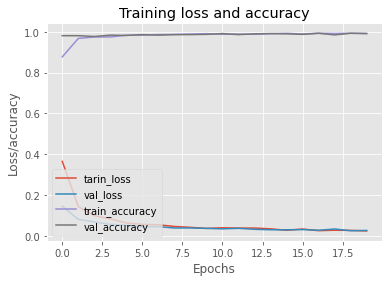

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0 ,N) , H.history['loss'] , label = 'tarin_loss')
plt.plot(np.arange(0 , N) , H.history['val_loss'] , label = 'val_loss')
plt.plot(np.arange(0 , N) ,H.history['accuracy'] , label = 'train_accuracy')
plt.plot(np.arange(0 ,N) ,H.history['val_accuracy'] , label = 'val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/accuracy')
plt.legend(loc="lower left")
plt.savefig('maskdetector_plot.png')

#Testing

In [ ]:
model_name = 'mask_detector.model'

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import imutils
import numpy as np
import os
import time
import cv2

In [ ]:
#load our all models.
prototxtpath = 'face_detector/deploy.prototxt'
weightspath = 'face_detector/res10_300x300_ssd_iter_140000.caffemodel'
maskNet = load_model('mask_detector.model')
faceNet = cv2.dnn.readNet(prototxtpath , weightspath)
print('[Model loaded]')

[Model loaded]


#define a function for detect face and mask

In [ ]:
#define a function for detect face and predict it have mask or not
def detect_and_predict(frame,faceNet,maskNet):
  #grab the frame and construct an blob image
  (h ,w) = frame.shape[:2]
  blob = cv2.dnn.blobFromImage(frame , 1.0 , (224 ,224) , (104.0 , 177.0 , 123.0))
  #pass the blob through facenet for facedetection
  faceNet.setInput(blob)
  detections = faceNet.forward()
  print(detections.shape)
  
	# initialize our list of faces, their corresponding locations,and the list of predictions from our face mask network
  faces = []
  locs = []
  preds = []

  #loop over the detection
  for i in range(0 ,detections.shape[2]):
    #extract the confidence or probability
    confidence = detections[0 , 0 , i , 2]
    
		# filter out weak detections by ensuring the confidence is greater than the minimum confidence
    if confidence > 0.5:
      # compute the (x, y)-coordinates of the bounding box for the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel bordering, resize it to 224x224, and preprocess it
      face = frame[startY:endY, startX:endX]
      face = cv2.cvtColor(face , cv2.COLOR_BGR2RGB)
      face = cv2.resize(face , (224,224))
      face = img_to_array(face)
      face = preprocess_input(face)
      faces.append(face)
      locs.append((startX, startY, endX, endY))

  # only make a predictions if at least one face was detected
  if len(faces)>0:
    # for faster inference we'll make batch predictions on *all* faces at the same time rather than one-by-one predictions 
    #in the above 'for' loop
    faces = np.array(faces , dtype = 'float32')
    #masknet predicition
    preds = maskNet.predict(faces ,batch_size=32)
	# return a 2-tuple of the face locations and their corresponding locations
  return (locs, preds)

camera streamin in colab

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

<IPython.core.display.Javascript object>

(1, 1, 200, 7)


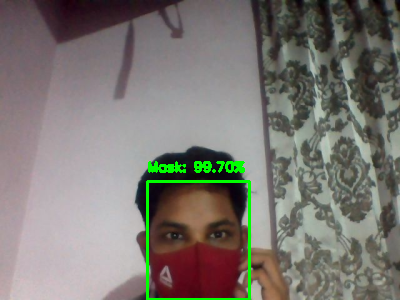

(1, 1, 200, 7)


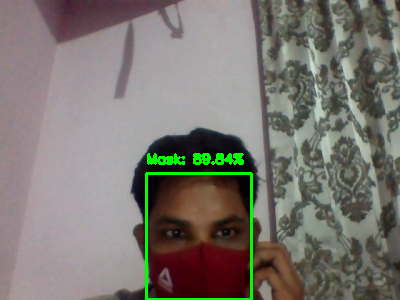

(1, 1, 200, 7)


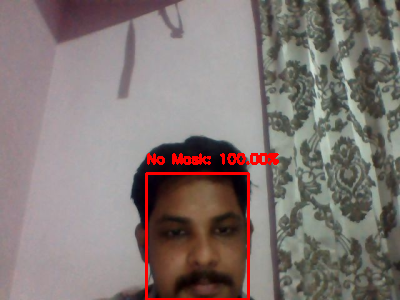

(1, 1, 200, 7)


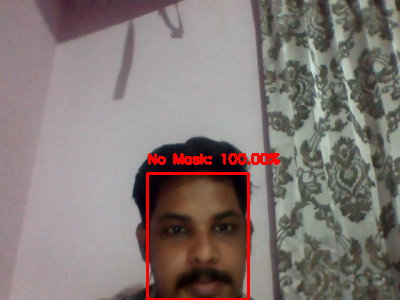

In [ ]:
from google.colab.patches import cv2_imshow
import imutils
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    frame = js_to_image(js_reply["img"])
    frame = imutils.resize(frame, width=400)
    (locs ,preds) = detect_and_predict(frame,faceNet,maskNet)
    # loop over the detected face locations and their corresponding locations
    for (box , pred) in zip(locs , preds):
      #unpack the boudning box nad location
      (startX, startY, endX, endY) = box
      (mask ,withoutMask) = pred
      # determine the class label and color we'll use to draw the bounding box and text
      label = 'Mask' if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      # include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    cv2_imshow(frame)